# InSAR denoiser training, validation, testing

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import random
from scipy import stats
import pickle

## Dataset construction

In [2]:
main_dir = '/mnt/working/brencher/sw/repos/indennt'
subset_types = ['signal', 'noise', 'dem', 'murp', 'era5']

# exclude non tif files, e.g. metadata
def list_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list

def subset_lists(main_dir, ds_type, subset_types):
    path_d = {}
    fn_list = []
    for type in subset_types:
        path_d[type] = f'{main_dir}/{ds_type}_subsets/{type}/'
        fn_list.append(list_tifs(os.listdir(path_d[type])))
    return path_d, fn_list[0]

train_d, train_list = subset_lists(main_dir, 'train', subset_types)
val_d, val_list = subset_lists(main_dir, 'val', subset_types)
test_d, test_list = subset_lists(main_dir, 'test', subset_types)

In [3]:
# define transforms
my_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [49]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, path_d, norm_list = [-41, 41, 0, 4374.6372], transform=None, 
                 norm=True, blurnoise=False, random_blur=False, flip=False, invert=False, rotate=False):
        self.file_list = file_list
        self.transform = transform
        self.signal_dir = path_d['signal']
        self.noise_dir = path_d['noise']
        self.dem_dir = path_d['dem']
        self.era5_dir = path_d['era5']
        self.murp_dir = path_d['murp']
        self.norm = norm
        self.blurnoise = blurnoise
        self.random_blur = random_blur
        self.flip = flip
        self.invert = invert
        self.rotate = rotate
        self.igram_min = norm_list[0]
        self.igram_max = norm_list[1]
        self.dem_min = norm_list[2]
        self.dem_max = norm_list[3]
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        signal_path = self.signal_dir+self.file_list[idx]
        noise_path = self.noise_dir+self.file_list[idx]
        dem_path = self.dem_dir+self.file_list[idx]
        era5_path = self.era5_dir+self.file_list[idx]
        murp_path = self.murp_dir+self.file_list[idx]
        
        signal = self.transform(Image.open(signal_path))
        noise = self.transform(Image.open(noise_path))
        dem = self.transform(Image.open(dem_path))
        era5 = self.transform(Image.open(era5_path))
        murp = self.transform(Image.open(murp_path))
        
        # Blur noise
        if self.blurnoise == True: # blur noise to mitigate signal from non atmospheric sources
            if self.random_blur == True:
                blur_params = [[13, 3], [15, 3.5], [17, 4], [19, 4.5], [21, 5]]
                while True:
                    index = round(np.random.normal(2, 0.4))
                    if -1 < index < 5:
                        break
                
                blur_select = blur_params[index]
                gblur = transforms.GaussianBlur(kernel_size=(blur_select[0], blur_select[0]), sigma=blur_select[1])
                noise = gblur(noise)
            else:
                gblur = transforms.GaussianBlur(kernel_size=(17, 17), sigma=4)
                noise = gblur(noise)
        
        # Generate scaled training images
        scalar = np.round(np.random.lognormal(4.5, 0.2), 3) # FOR PLOTTING: 5, 0.2, for training 4, 0.5
        signal = signal*scalar*-1 #multiply by -1 because mintpy has a reversed sign convention
        igram = noise+signal
        
        # set local ref for era5
        ref_index = signal.abs().argmin().item() # location of lowest signal in velocity map
        corr_diff = (igram.flatten()[ref_index] - era5.flatten()[ref_index]).item()
        era5 = era5+corr_diff
        
        # set local ref for murp
        corr_diff = (igram.flatten()[ref_index] - murp.flatten()[ref_index]).item()
        murp = murp+corr_diff
        
        # correct era5 and murp
        era5_corr = igram-era5
        murp_corr = igram-murp
        
        # correct hp
        hp_filter = transforms.GaussianBlur(kernel_size=(17, 17), sigma=4)
        igram_filtered = hp_filter(igram)
        hp_corr = igram - igram_filtered
        
        if self.invert==True:
            if random.random() < 0.5:
                igram = igram*-1
                signal = signal*-1
                noise = noise*-1
                era5_corr = era5_corr *-1
                murp_corr = murp_corr *-1
                hp_corr = hp_corr *-1
            
        if self.norm == True:
            igram = 2*(((igram-self.igram_min)/(self.igram_max-self.igram_min)))-1
            signal = 2*(((signal-self.igram_min)/(self.igram_max-self.igram_min)))-1
            noise = 2*(((noise-self.igram_min)/(self.igram_max-self.igram_min)))-1
            dem = 2*(((dem-self.dem_min)/(self.dem_max-self.dem_min)))-1
        
        if self.flip==True:
            flip_dim = []
            if random.random() < 0.25:
                flip_dim = [0]
            elif random.random() > 0.25 and random.random() < 0.5:
                flip_dim = [1]
            elif random.random() > 0.5 and random.random() < 0.75:
                flip_dim = [0, 1]
            
            igram = torch.flip(igram, flip_dim)
            signal = torch.flip(signal, flip_dim)
            noise = torch.flip(noise, flip_dim)
            era5_corr = torch.flip(era5_corr, flip_dim)
            murp_corr = torch.flip(murp_corr, flip_dim)
            hp_corr = torch.flip(hp_corr, flip_dim)
            dem = torch.flip(dem, flip_dim)
        
        if self.rotate==True:
            angle = random.randint(0, 180)
            igram = transforms.functional.rotate(igram, angle)
            signal = transforms.functional.rotate(signal, angle)
            noise = transforms.functional.rotate(noise, angle)
            era5_corr = transforms.functional.rotate(era5_corr, angle)
            murp_corr = transforms.functional.rotate(murp_corr, angle)
            hp_corr = transforms.functional.rotate(hp_corr, angle)
            dem = transforms.functional.rotate(dem, angle)
            
         
        return igram, signal, noise, dem, era5_corr, murp_corr, hp_corr

### Find dataset max and min for normalization

In [ ]:
# # dataset min and max for normalization
# def get_max(data_list, data_d, transforms=my_transforms):
#     max = 0 
#     min = 0
#     data = dataset(data_list, data_d, transform=transforms, blurnoise=True, norm=False)
#     loader = torch.utils.data.DataLoader(dataset = data, batch_size=1, shuffle=False)
#     for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(loader):
#         if (i+1)%1000 == 0: 
#             print(f'loop {i+1}/{data.filelength}')
#         if igram.max() > max:
#             max = igram.max()

#     return max

# get_max(train_list, train_d)

# # train igram max = 35.4796
# # val igram max = 27.1600
# # will set at 37 to be safe

# # train dem max, min: 4374.6372, 0
# # val dem max, min: 4353.3779, 0

# # updating snr for run 8: 
# # train igram max: 36.0537
# # will set at 37 to be safe

# # updating snr for run 9 
# # train igram max: 39.7634
# # will set at 41 to be safe

In [5]:
def undo_norm(array, min=-41, max=41):
    array = ((array+1)*((max-min)/2))+min
    return array

In [50]:
# create dataloaders
train_data = dataset(train_list, train_d, transform=my_transforms, blurnoise=True, random_blur=True, flip=True, invert=True, rotate=True)
val_data = dataset(val_list, val_d, transform=my_transforms, blurnoise=True, random_blur=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

## Examine dataset

In [ ]:
# # plot all original data 
# num_images = 5

# for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(val_loader):
#     if i < num_images:
#         igram = undo_norm(igram.squeeze())
#         signal_target = undo_norm(signal_target.squeeze())
#         noise_target = undo_norm(noise_target.squeeze())
        
#         f, ax = plt.subplots(2, 5, figsize=(10,5), sharey=True, sharex=True)
#         ax[0][0].imshow(igram, cmap='RdBu_r', vmin=-10, vmax=10) 
#         ax[0][0].set_title('training')
#         ax[0][1].imshow(signal_target, cmap='RdBu_r', vmin=-1, vmax=1)
#         ax[0][1].set_title('target signal')
#         ax[0][2].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
#         ax[0][2].set_title('ERA5 corrected')
#         ax[0][3].imshow(murp_corr.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
#         ax[0][3].set_title('MuRP corrected')
#         ax[0][4].imshow(hp_corr.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
#         ax[0][4].set_title('HP corrected')
        
#         ax[1][0].imshow(dem.squeeze(), cmap='viridis') 
#         ax[1][0].set_title('DEM')
#         ax[1][1].imshow(noise_target, cmap='RdBu_r', vmin=-10, vmax=10)
#         ax[1][1].set_title('target noise')
#         ax[1][2].imshow((igram-era5_corr.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
#         ax[1][2].set_title('ERA5 noise')
#         ax[1][3].imshow((igram-murp_corr.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
#         ax[1][3].set_title('MuRP noise')
#         ax[1][4].imshow((igram-hp_corr.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
#         ax[1][4].set_title('HP noise')
#         f.tight_layout()
#     else:
#         break
            
#             #plt.savefig(f'input_correctons{i}.png', dpi=300)

In [ ]:
# # plot normalized training inputs 
# num_images = 5

# for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(val_loader):
#     if i < num_images:
#             f, ax = plt.subplots(1, 4, figsize=(10,4), sharey=True)
#             ax[0].imshow(igram.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None) 
#             ax[0].set_title('training')
#             ax[1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None)
#             ax[1].set_title('target signal')
#             ax[2].imshow(noise_target.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None)
#             ax[2].set_title('target noise')
#             ax[3].imshow(dem.squeeze(), cmap='viridis', vmin=-1, vmax=1, interpolation=None)
#             ax[3].set_title('DEM')
#             f.tight_layout()
#     else: 
#         break

## Define network

In [7]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=bias)


def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)


def check_valid_activation(choice):
    if choice not in ['relu', 'lrelu', 'prelu']:
        raise ValueError(f"'{choice}' is not a valid activation function. Choose among ['relu', 'lrelu', 'prelu'].\n")


def upconv(in_channels, out_channels, mode='transpose'):
    # stride=2 implies upsampling by a factor of 2
    get_up_mode = nn.ModuleDict([
        ['bilinear', nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2), conv1x1(in_channels, out_channels))],
        ['transpose', nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)]
    ])

    return get_up_mode[mode]


def get_activation(choice):
    activation_functions = nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['lrelu', nn.LeakyReLU(inplace=True)],
        ['prelu', nn.PReLU()]
        ])
    return activation_functions[choice]


def conv_block(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Partial encoder block consisting of a 3×3 convolutional layer with stride 1, followed by batch normalization
    (optional) and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


def conv_up_block(in_channels, out_channels, activation='relu', do_BN=True, up_mode='transpose', *args, **kwargs):
    """
    Decoder block consisting of an up-convolutional layer, followed by a 3×3 convolutional layer with stride 1,
    batch normalization (optional), and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                get_activation(activation))
            )
    else:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
                get_activation(activation))
            )


def bottleneck(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Bottleneck block.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


class SkipConnection(nn.Module):
    def __init__(self):
        super(SkipConnection, self).__init__()

    def forward(self, x_skip, x_up):
        return x_skip + x_up


class UNet(nn.Module):
    def __init__(self, n_input_channels=2, start_kernel=64, max_filter_depth=512, depth=5,
                 act_fn_encoder='relu', act_fn_decoder='relu', act_fn_bottleneck='relu', up_mode='transpose',
                 do_BN=False, bias_conv_layer=True, outer_skip=True, outer_skip_BN=False):
        """
        UNet network architecture.
        :param n_input_channels:    int, number of input channels
        :param start_kernel:        int, number of filters of the first convolutional layer in the encoder
        :param max_filter_depth:    int, maximum filter depth
        :param depth:               int, number of downsampling and upsampling layers (i.e., number of blocks in the
                                    encoder and decoder)
        :param act_fn_encoder:      str, activation function used in the encoder
        :param act_fn_decoder:      str, activation function used in the decoder
        :param act_fn_bottleneck:   str, activation function used in the bottleneck
        :param up_mode:             str, upsampling mode
        :param do_BN:               boolean, True to perform batch normalization after every convolutional layer,
                                    False otherwise
        :param bias_conv_layer:     boolean, True to activate the learnable bias of the convolutional layers,
                                    False otherwise
        :param outer_skip:          boolean, True to activate the long residual skip connection that adds the
                                    initial DSM to the output of the last decoder layer, False otherwise
        :param outer_skip_BN:       boolean, True to add batch normalization to the long residual skip connection,
                                    False otherwise
        """

        super(UNet, self).__init__()

        check_valid_activation(act_fn_encoder)
        check_valid_activation(act_fn_decoder)
        check_valid_activation(act_fn_bottleneck)

        if up_mode not in ['transpose', 'bilinear']:
            raise ValueError(f"'{up_mode}' is not a valid mode for upsampling. Choose among ['transpose', 'bilinear'] "
                             "to specify 'up_mode'.\n")

        self.n_input_channels = n_input_channels
        self.start_kernel = start_kernel
        self.depth = depth
        self.act_fn_encoder = act_fn_encoder
        self.act_fn_decoder = act_fn_decoder
        self.act_fn_bottleneck = act_fn_bottleneck
        self.up_mode = up_mode
        self.max_filter_depth = max_filter_depth
        self.do_BN = do_BN
        self.bias_conv_layer = bias_conv_layer
        self.do_outer_skip = outer_skip
        self.do_outer_skip_BN = outer_skip_BN
        self.filter_depths = [self.start_kernel * (2 ** i) for i in range(self.depth)]

        # Restrict the maximum filter depth to a predefined value
        self.filter_depths = [self.max_filter_depth if i > self.max_filter_depth else i for i in self.filter_depths]

        # Set up the encoder
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Sequential(
            conv_block(self.n_input_channels, self.start_kernel, activation=self.act_fn_encoder, do_BN=self.do_BN),
            nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        for in_channel, out_channel in zip(self.filter_depths, self.filter_depths[1:]):
            self.encoder.append(nn.Sequential(
                conv_block(in_channel, out_channel, activation=self.act_fn_encoder, do_BN=self.do_BN),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        # Set up the bottleneck
        self.bottleneck = bottleneck(self.filter_depths[-1], self.filter_depths[-1], activation=self.act_fn_bottleneck,
                                     do_BN=self.do_BN)

        # Set up the decoder
        self.decoder = nn.ModuleList()
        self.filter_depths_up = list(reversed(self.filter_depths))

        for in_channel, out_channel in zip(self.filter_depths_up[:-1], self.filter_depths_up[1:]):
            self.decoder.append(conv_up_block(in_channel, out_channel, activation=self.act_fn_decoder,
                                              up_mode=self.up_mode, do_BN=self.do_BN))
        self.decoder.append(upconv(self.filter_depths_up[-1], self.filter_depths_up[-1], up_mode))

        # Set up the final layer of the decoder
        self.last_layer = conv3x3(self.start_kernel, 1, bias=self.bias_conv_layer)

        # Skip connection
        self.skipconnect = SkipConnection()

        # Batch normalization added to the long residual skip connection
        if self.do_outer_skip:
            self.layer_outer_skip = nn.ModuleList()
            if self.do_outer_skip_BN:
                self.layer_outer_skip.append(nn.BatchNorm2d(1))
            self.layer_outer_skip.append(SkipConnection())

    def forward(self, x, dem):
        skip_connections = []
        x = torch.cat((x, dem), dim=1)
        out = x

        # Encoder (save intermediate outputs for skip connections)
        for index, layer in enumerate(self.encoder):
            layer_conv = layer[:-1]  # all layers before the pooling layer (at depth index)
            layer_pool = layer[-1]   # pooling layer (at depth index)

            out_before_pool = layer_conv(out)
            skip_connections.append(out_before_pool)
            out = layer_pool(out_before_pool)

        # Bottleneck
        out = self.bottleneck(out)

        # Decoder + skip connections
        index_max = len(self.decoder) - 1
        for index, layer in enumerate(self.decoder):
            if index <= index_max - 1:
                layer_upconv = layer[0]  # upconv layer
                layer_conv = layer[1::]  # all other layers (conv, batchnorm, activation)

                out_temp = layer_upconv(out)
                out = self.skipconnect(skip_connections[-1 - index], out_temp)
                out = layer_conv(out)
            else:
                out_temp = layer(out)   # upconv of last layer
                out = self.skipconnect(skip_connections[-1 - index], out_temp)

        # Last layer of the decoder
        out = self.last_layer(out)

        # Add long residual skip connection
        if self.do_outer_skip:
            if self.layer_outer_skip.__len__() == 2:
                # pipe input through a batch normalization layer before adding it to the output of the last
                # decoder layer
                bn = self.layer_outer_skip[0]
                x_0 = x[:, 0, :, :]       # use channel 0 only
                x_0 = x_0.unsqueeze(1)
                x = bn(x_0)

            # add (batchnorm) input to the output of the last decoder layer
            add = self.layer_outer_skip[-1]
            x_0 = x[:, 0, :, :]
            x_0 = x_0.unsqueeze(1)

            out = add(x_0, out)  # use channel 0 only

        return out

## Train model

In [8]:
#load previous model
model = UNet()
model.load_state_dict(torch.load('../../models/noisemodel1.4_174epochs'))
model.to('cuda')
model.eval()

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): MaxPool2d(kernel_size=2, s

In [ ]:
# %%time

# #Define optimizer
# model = UNet()
# model.to('cuda') # run on gpu
# optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
# loss_fn   = nn.L1Loss()
# epochs = 300
# torch.autograd.set_detect_anomaly(True)

# train_loss = []
# val_loss = []
# counter = 0

# for epoch in range(epochs):
#     print(f'\nstarting epoch {epoch}')
#     epoch_loss = []
#     val_temp_loss = []
    
#     #loop through training data 
#     for (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in train_loader:
#         model.train()
#         optimizer.zero_grad()
#         out = torch.clamp(model(igram.to('cuda'), dem.to('cuda')), -1, 1) # Generate noise predictions
    
#         # calculate predicted signals 
#         signal_pred = igram.to('cuda')-out.to('cuda')
#         loss = loss_fn(signal_pred.to('cuda'), signal_target.to('cuda')) # calculate loss 
#         epoch_loss.append(loss.item()) # add batch loss to epoch loss list
        
#         loss.backward() #Propagate the gradients in backward pass
#         optimizer.step() 

#     train_loss.append(np.mean(epoch_loss))
#     print(f'training loss: {np.mean(epoch_loss)}')
    
#     scheduler.step(np.mean(epoch_loss))
    
#     # run model on validation data 
#     for (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in val_loader:
#         with torch.no_grad():
#             model.eval()
            
#             out = torch.clamp(model(igram.to('cuda'), dem.to('cuda')), -1, 1) #Generate predictions using the model
#             signal_pred = igram.to('cuda')-out.to('cuda')
           
#             loss = loss_fn(signal_pred.to('cuda'), signal_target.to('cuda')) #Loss/error
#             val_temp_loss.append(loss.item())
    
#     # calculate loss over previous 10 epochs for early stopping later
#     if epoch > 20:
#         past_loss = np.mean(val_loss[-20:-10])
    
#     val_loss.append(np.mean(val_temp_loss))
#     print(f'validation loss: {np.mean(val_temp_loss)}')
        
#     with open('../../loss/val_loss.pkl', 'wb') as f:
#         pickle.dump(val_loss, f)
        
#     with open('../../loss/train_loss.pkl', 'wb') as f:
#         pickle.dump(train_loss, f)
    
    
#     # implement early stopping
#     if epoch > 20:
#         current_loss = np.mean(val_loss[-10:-1])
#         if current_loss > past_loss:
#             counter +=1
#             if counter >= 10:
#                 torch.save(model.state_dict(), f'../../models/noisemodel1.4_{epoch+1}epochs')
#                 print('early stopping triggered')
#                 break
#         else:
#             counter = 0

## Examine results

In [ ]:
# random.seed(10)

In [ ]:
# with open('../loss/val_loss.pkl', 'rb') as f:
#     val_loss = pickle.load(f)
        
# with open('../loss/train_loss.pkl', 'rb') as f:
#     train_loss = pickle.load(f)

# with open('../loss/val_loss_p2.pkl', 'rb') as f:
#     val_loss_p2 = pickle.load(f)
        
# with open('../loss/train_loss_p2.pkl', 'rb') as f:
#     train_loss_p2 = pickle.load(f)

# train_loss.extend(train_loss_p2)
# val_loss.extend(val_loss_p2)

In [ ]:
# #plot loss over all epochs
# f, ax = plt.subplots(figsize=(10,5))
# ax.plot(train_loss, label='training')
# ax.plot(val_loss, label='validation')
# ax.set_xlabel('epoch')
# ax.set_ylabel('L1 loss')
# ax.set_title('Loss')
# ax.legend()
# plt.savefig('../../figs/loss_1.4.png', dpi=300)

In [ ]:
# # raw inputs and outputs
# num_images=5

# for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(val_loader):
#     if i < num_images:
#         with torch.no_grad():
#             noise = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
#             signal = torch.clamp(igram.to('cpu') - noise.to('cpu'), -1, 1)
            
#             f, ax = plt.subplots(2, 3, figsize=(15,10))
#             ax[0][0].imshow(igram.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None) 
#             ax[0][0].set_title('original interferogram')
#             ax[0][1].imshow(noise_target.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None)
#             ax[0][1].set_title('true noise')
#             ax[0][2].imshow(noise.squeeze().to('cpu'), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None)
#             ax[0][2].set_title('predicted noise')
#             ax[1][0].imshow(dem.squeeze().to('cpu'), cmap='viridis', vmin=-1, vmax=1, interpolation=None)
#             ax[1][0].set_title('DEM')
#             ax[1][1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None)
#             ax[1][1].set_title('true signal')
#             ax[1][2].imshow(signal.squeeze(), cmap='RdBu_r', vmin=-0.25, vmax=0.25, interpolation=None)
#             ax[1][2].set_title('predicted signal')
  
#             plt.tight_layout()
#             #plt.savefig(f'pred_raw{i}.png', dpi=300)
#     else: 
#         break

In [ ]:
# # un-normalized inputs and outputs
# num_images=5
# for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(val_loader):
#     if i < num_images:
#         with torch.no_grad():
#             noise = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
#             signal = torch.clamp(igram.to('cpu') - noise.to('cpu'), -1, 1)
            
#             igram = undo_norm(igram.squeeze())
#             signal = undo_norm(signal.squeeze())
#             noise = undo_norm(noise.squeeze())
#             signal_target = undo_norm(signal_target.squeeze())
#             noise_target = undo_norm(noise_target.squeeze())
            
#             f, ax = plt.subplots(2, 3, figsize=(15,10))
#             ax[0][0].imshow(igram, cmap='RdBu_r', vmin=-10, vmax=10, interpolation=None) 
#             ax[0][0].set_title('original interferogram')
#             ax[0][1].imshow(noise_target.squeeze(), cmap='RdBu_r', vmin=-10, vmax=10, interpolation=None)
#             ax[0][1].set_title('true noise')
#             ax[0][2].imshow(noise.squeeze().to('cpu'), cmap='RdBu_r', vmin=-10, vmax=10, interpolation=None)
#             ax[0][2].set_title('predicted noise')
#             ax[1][0].imshow(dem.squeeze().to('cpu'), cmap='viridis', vmin=-1, vmax=1, interpolation=None)
#             ax[1][0].set_title('DEM')
#             ax[1][1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1, interpolation=None)
#             ax[1][1].set_title('true signal')
#             ax[1][2].imshow(signal.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1, interpolation=None)
#             ax[1][2].set_title('predicted signal')
            
#             plt.tight_layout()
#             #plt.savefig(f'pred_raw{i}.png', dpi=300)
#     else:
#         break

## Evaluate results with training and validation

In [54]:
# define dataloaders for evaluation
val_data_ssim = dataset(val_list, val_d, transform=my_transforms, blurnoise=True, random_blur=True)
train_data_ssim = dataset(train_list, train_d, transform=my_transforms, blurnoise=True, random_blur=True)
val_loader_ssim = torch.utils.data.DataLoader(dataset = val_data_ssim, batch_size=1, shuffle=True)
train_loader_ssim = torch.utils.data.DataLoader(dataset = train_data_ssim, batch_size=1, shuffle=True)

In [ ]:
# def ssim_lists(model, data_loader):
#     # initialize lists 
#     ssim_list_uncorrected = []
#     ssim_list_model = []
#     ssim_list_era5 = []
#     ssim_list_murp = []
#     ssim_list_hp = []
    
#     for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
#         # model preds
#         noise = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
#         signal = torch.clamp(igram.to('cpu') - noise.to('cpu'), -1, 1)
        
#         # denormalize
#         igram = undo_norm(igram.squeeze().detach())
#         signal = undo_norm(signal.squeeze().detach())
#         signal_target = undo_norm(signal_target.squeeze().detach())
        
#         # uncorrected SSIM
#         # calc ssim
#         ssim_value_uncorrected = ssim(signal_target.numpy(), igram.numpy(), gaussian_weights=True, data_range=(igram.max()-igram.min()).item())
#         ssim_list_uncorrected.append(ssim_value_uncorrected)
        
        
#         # calc ssim
#         ssim_value_model = ssim(signal_target.numpy(), signal.numpy(), gaussian_weights=True,  data_range=(signal.max()-signal.min()).item())
#         ssim_list_model.append(ssim_value_model)
    
#         # era5 corrected SSIM
#         ssim_value_era5 = ssim(signal_target.numpy(), era5_corr.squeeze().numpy(), gaussian_weights=True, data_range=(era5_corr.max()-era5_corr.min()).item())
#         ssim_list_era5.append(ssim_value_era5)

#         # murp corrected SSIM
#         ssim_value_murp = ssim(signal_target.numpy(), murp_corr.squeeze().numpy(), gaussian_weights=True, data_range=(murp_corr.max()-murp_corr.min()).item())
#         ssim_list_murp.append(ssim_value_murp)
    
#         # hp filter corrected SSIM
#         ssim_value_hp = ssim(signal_target.numpy(), hp_corr.squeeze().numpy(), gaussian_weights=True, data_range=(hp_corr.max()-hp_corr.min()).item())
#         ssim_list_hp.append(ssim_value_hp)
    
#     print('mean ssim before correction:', np.mean(ssim_list_uncorrected),
#           '\nmean ssim model correction:', np.mean(ssim_list_model), 
#           '\nmean ssim era5 correction:', np.mean(ssim_list_era5),
#           '\nmean ssim murp correction:', np.mean(ssim_list_murp),
#           '\nmean ssim high pass filter correction:', np.mean(ssim_list_hp))
    
#     return ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_murp, ssim_list_hp

In [ ]:
# def mse_lists(model, data_loader):
#     # initialize lists 
#     mse_list_uncorrected = []
#     mse_list_model = []
#     mse_list_era5 = []
#     mse_list_murp = []
#     mse_list_hp = []
    
#     for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
        
#         # model preds
#         noise = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
#         signal = torch.clamp(igram.to('cpu') - noise.to('cpu'), -1, 1).detach()
        
#         # denormalize
#         igram = undo_norm(igram.squeeze().detach())
#         signal = undo_norm(signal.squeeze().detach())
#         signal_target = undo_norm(signal_target.squeeze())
        
#         # uncorrected MSE
#         # calc ssim
#         mse_value_uncorrected = mse(signal_target.numpy(), igram.numpy())
#         mse_list_uncorrected.append(mse_value_uncorrected)
    
#         # Model corrected MSE
#         # calc ssim
#         mse_value_model = mse(signal_target.numpy(), signal.numpy())
#         mse_list_model.append(mse_value_model)
    
#         # era5 corrected MSE
#         mse_value_era5 = mse(signal_target.numpy(), era5_corr.squeeze().numpy())
#         mse_list_era5.append(mse_value_era5)

#         # murp corrected MSE
#         mse_value_murp = mse(signal_target.numpy(), murp_corr.squeeze().numpy())
#         mse_list_murp.append(mse_value_murp)
    
#         # hp filter corrected MSE
#         mse_value_hp = mse(signal_target.numpy(), hp_corr.squeeze().numpy())
#         mse_list_hp.append(mse_value_hp)
    
#     print('mean rmse before correction:', np.mean(mse_list_uncorrected),
#           '\nmean rmse model correction:', np.mean(mse_list_model), 
#           '\nmean rmse era5 correction:', np.mean(mse_list_era5),
#           '\nmean rmse murp correction:', np.mean(mse_list_murp),
#           '\nmean rmse high pass filter correction:', np.mean(mse_list_hp))
    
#     return mse_list_uncorrected, mse_list_model, mse_list_era5, mse_list_murp, mse_list_hp

In [ ]:
# print('val data ssim')
# val_ssim_list_uncorrected, val_ssim_list_model, val_ssim_list_era5, val_ssim_list_murp, val_ssim_list_hp = ssim_lists(model, val_loader_ssim)
# print('training data ssim')
# train_ssim_list_uncorrected, train_ssim_list_model, train_ssim_list_era5, train_ssim_list_murp, train_ssim_list_hp = ssim_lists(model, train_loader_ssim)

In [ ]:
# print('val data rmse')
# val_mse_list_uncorrected, val_mse_list_model, val_mse_list_era5, val_mse_list_murp, val_mse_list_hp = mse_lists(model, val_loader_ssim)
# print('training data rmse')
# train_mse_list_uncorrected, train_mse_list_model, train_mse_list_era5, train_mse_list_murp, train_mse_list_hp = mse_lists(model, train_loader_ssim)

In [ ]:
# # Calculate SNR
# def rms(tensor):
#     rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
#     return rms

# def snr(model, data_loader):
#     snr_list = []

#     for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(data_loader):
#         igram = undo_norm(igram.squeeze().detach())
#         signal_target = undo_norm(signal_target.squeeze().detach())
#         snr_list.append(rms(signal_target)/rms(igram-signal_target))

#     print('mean snr of images:', np.mean(snr_list), 'stdev of SNR of images:', np.std(snr_list))
    
#     return snr_list

In [ ]:
# val_snr_list = snr(model, val_loader_ssim)
# train_snr_list = snr(model, train_loader_ssim)

In [55]:
def rms(tensor):
    rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
    return rms

def snr_single(signal_target, igram):
    snr_val = (rms(signal_target)/rms(igram-signal_target))
    return snr_val

def ssim_single(signal_target, pred):
    ssim_val = ssim(signal_target.squeeze().detach().numpy(),
                    pred.squeeze().detach().numpy(), 
                    gaussian_weights=True, data_range=(pred.max()-pred.min()).item())
    return ssim_val

interferogram SNR: 0.22780103981494904
uncorrected SSIM: 0.11095678276702535
CNN corrected SSIM: 0.521801886486206
ERA5 corrected SSIM: 0.22962201425658604
MuRP corrected SSIM: 0.2240082224979698
HP corrected SSIM: 0.35549500450420457


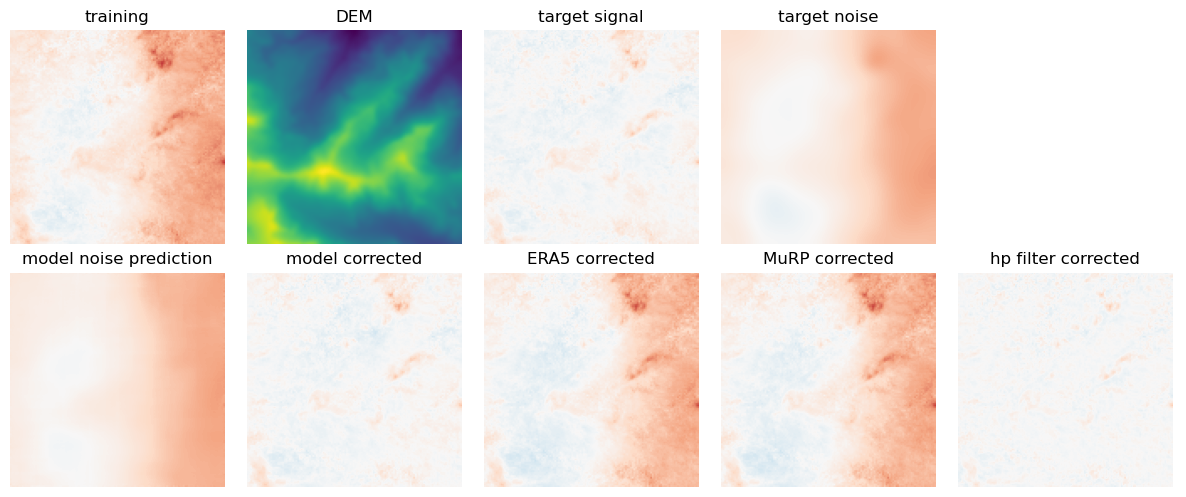

In [121]:
#example corrections for paper fig
plt.style.use('default')

num_images = 1

for i, (igram, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr) in enumerate(val_loader_ssim):
    if i < num_images:
        noise_pred = model(igram.to('cuda'), dem.to('cuda')) #Generate predictions using the model
        signal_pred = torch.clamp(igram.to('cpu') - noise_pred.to('cpu'), -1, 1)

        igram = undo_norm(igram.squeeze().detach())
        signal_target = undo_norm(signal_target.squeeze())
        noise_target = undo_norm(noise_target.squeeze())
        noise_pred = undo_norm(noise_pred.squeeze().detach().to('cpu'))
        signal_pred = undo_norm(signal_pred.squeeze().detach().to('cpu'))
        
        # Interferogram SNR
        print(f'interferogram SNR: {snr_single(signal_target, igram)}')
        # Uncorrected ssim
        print(f'uncorrected SSIM: {ssim_single(signal_target, igram)}')
        # CNN corrected ssim
        print(f'CNN corrected SSIM: {ssim_single(signal_target, signal_pred)}')
        # ERA5 corrected ssim
        print(f'ERA5 corrected SSIM: {ssim_single(signal_target, era5_corr)}')
        # murp corrected ssim
        print(f'MuRP corrected SSIM: {ssim_single(signal_target, murp_corr)}')
        # HP corrected ssim
        print(f'HP corrected SSIM: {ssim_single(signal_target, hp_corr)}')
        
        f, ax = plt.subplots(2, 5, figsize=(12,5))
        # interferogram
        ax[0, 0].imshow(igram, cmap='RdBu_r', vmin=-10, vmax=10) 
        ax[0, 0].set_title('training')
        ax[0, 0].axis('off')
        # dem
        ax[0, 1].imshow(dem.squeeze(), cmap='viridis') 
        ax[0, 1].set_title('DEM')
        ax[0, 1].axis('off')
        # target signal
        ax[0, 2].imshow(signal_target, cmap='RdBu_r', vmin=-10, vmax=10)
        ax[0, 2].set_title('target signal')
        ax[0, 2].axis('off')
        #target noise
        ax[0, 3].imshow(noise_target, cmap='RdBu_r', vmin=-10, vmax=10)
        ax[0, 3].set_title('target noise')
        ax[0, 3].axis('off')
        
        ax[0, 4].axis('off')
        
        # CNN noise prediction
        ax[1, 0].imshow(noise_pred, cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1, 0].set_title('model noise prediction')
        ax[1, 0].axis('off')
        # CNN signal prediction
        ax[1, 1].imshow(signal_pred, cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1, 1].set_title('model corrected')
        ax[1, 1].axis('off')
        # ERA5 signal prediction
        ax[1, 2].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1, 2].set_title('ERA5 corrected')
        ax[1, 2].axis('off')
        # murp signal prediction
        ax[1, 3].imshow(murp_corr.squeeze(), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1, 3].set_title('MuRP corrected')
        ax[1, 3].axis('off')
        # HP signal prediction
        ax[1, 4].imshow(hp_corr.squeeze(), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1, 4].set_title('hp filter corrected')
        ax[1, 4].axis('off')
        f.tight_layout()
        
        plt.savefig('../../figs/pred_example4.png', dpi=400)
    
        if i+1 >= num_images:
            break
        

pred_example
interferogram SNR: 1.0959817171096802
uncorrected SSIM: 0.49491308993844974
CNN corrected SSIM: 0.6160475978850088
ERA5 corrected SSIM: 0.4875292268918117
MuRP corrected SSIM: 0.5507798440096329
HP corrected SSIM: 0.3261401004592315

pred_example2
interferogram SNR: 0.07073532044887543
uncorrected SSIM: 0.03941563347669969
CNN corrected SSIM: 0.34337970765467624
ERA5 corrected SSIM: 0.12658932071242346
MuRP corrected SSIM: -0.053397286606253536
HP corrected SSIM: 0.20243116222779953

pred_example3
interferogram SNR: 0.10542032867670059
uncorrected SSIM: -0.06699941982181326
CNN corrected SSIM: 0.47958389448036853
ERA5 corrected SSIM: 0.3358634008980684
MuRP corrected SSIM: 0.36387249065240096
HP corrected SSIM: 0.14409060461297474



In [ ]:
def df_for_plotting(snr_list, ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_murp, ssim_list_hp):

    roll_count = 200
    q_low = 25
    q_high = 75

    ssim_dict = {'snr': snr_list,
                 'ssim_uncorrected':ssim_list_uncorrected,
                 'ssim_model':ssim_list_model,
                 'ssim_era5':ssim_list_era5,
                 'ssim_murp':ssim_list_murp,
                 'ssim_hp':ssim_list_hp}
    ssim_df = pd.DataFrame(ssim_dict)

    # uncorrected ssim
    ssim_df['ssim_uncorrected_mean'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).mean()
    ssim_df[f'ssim_uncorrected_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_uncorrected_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # model corrected ssim
    ssim_df['ssim_model_mean'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).mean()
    ssim_df[f'ssim_model_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_model_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_era5_mean'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).mean()
    ssim_df[f'ssim_era5_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_era5_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # murp corrected ssim
    ssim_df['ssim_murp_mean'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).mean()
    ssim_df[f'ssim_murp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_murp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_hp_mean'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).mean()
    ssim_df[f'ssim_hp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_hp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_high/100)
    
    return ssim_df

In [ ]:
val_ssim_df=df_for_plotting(val_snr_list, val_ssim_list_uncorrected, val_ssim_list_model, val_ssim_list_era5, val_ssim_list_murp, val_ssim_list_hp)
train_ssim_df=df_for_plotting(train_snr_list, train_ssim_list_uncorrected, train_ssim_list_model, train_ssim_list_era5, train_ssim_list_murp, train_ssim_list_hp)

In [ ]:
# can't plot exactly 0 snr due to log scale
train_ssim_df_clean = train_ssim_df[train_ssim_df.snr != 0]
val_ssim_df_clean = val_ssim_df[val_ssim_df.snr != 0]

In [ ]:
sns.set_theme()

f, ax = plt.subplots(2, 5, figsize=(10,5), sharex=True, sharey=True)

# val uncorrected 
sns.histplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0, 0].set_xscale('log')

sns.histplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel('SSIM')
ax[0, 0].set_title('uncorrected')

sns.lineplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# val model corrected
sns.histplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 1].set_xscale('log')
ax[0, 1].set_ylabel('SSIM')
ax[0, 1].set_title('CNN')

sns.lineplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# val era5 corrected
sns.histplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 2].set_xscale('log')
ax[0, 2].set_ylabel('SSIM')
ax[0, 2].set_title('ERA5')

sns.lineplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# val murp corrected
sns.histplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 3].set_xscale('log')
ax[0, 3].set_ylabel('SSIM')
ax[0, 3].set_title('MuRP')

sns.lineplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)


# val hp corrected
sns.histplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 4].set_xscale('log')
ax[0, 4].set_xlabel('SNR')
ax[0, 4].set_ylabel('SSIM')
ax[0, 4].set_title('low-pass filter')

sns.lineplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train uncorrected 
sns.histplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel('SSIM')
ax[1, 0].set_xlabel('SNR')

sns.lineplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# train model corrected
sns.histplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# train era5 corrected
sns.histplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# train murp corrected
sns.histplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 3].set_xscale('log')
ax[1, 3].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train hp corrected
sns.histplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 4].set_xscale('log')
ax[1, 4].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)


#plt.savefig('SSIMv2.png', dpi=300)

In [ ]:
val_mse_df=df_for_plotting(val_snr_list, val_mse_list_uncorrected, val_mse_list_model, val_mse_list_era5, val_mse_list_murp, val_mse_list_hp)
train_mse_df=df_for_plotting(train_snr_list, train_mse_list_uncorrected, train_mse_list_model, train_mse_list_era5, train_mse_list_murp, train_mse_list_hp)

In [ ]:
# can't plot exactly 0 snr due to log scale
train_mse_df_clean = train_mse_df[train_ssim_df.snr != 0]
val_mse_df_clean = val_mse_df[val_ssim_df.snr != 0]

In [ ]:
sns.set_theme()

f, ax = plt.subplots(2, 5, figsize=(10,5), sharex=True, sharey=True)

# val uncorrected 
sns.histplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

sns.histplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel('RMSE')
ax[0, 0].set_title('uncorrected')

sns.lineplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# val model corrected
sns.histplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel('RMSE')
ax[0, 1].set_title('CNN')

sns.lineplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# val era5 corrected
sns.histplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 2].set_xscale('log')
ax[0, 2].set_yscale('log')
ax[0, 2].set_ylabel('RMSE')
ax[0, 2].set_title('ERA5')

sns.lineplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# val murp corrected
sns.histplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 3].set_xscale('log')
ax[0, 3].set_yscale('log')
ax[0, 3].set_ylabel('RMSE')
ax[0, 3].set_title('MuRP')

sns.lineplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)


# val hp corrected
sns.histplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 4].set_xscale('log')
ax[0, 4].set_yscale('log')
ax[0, 4].set_xlabel('SNR')
ax[0, 4].set_ylabel('RMSE')
ax[0, 4].set_title('low-pass filter')

sns.lineplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train uncorrected 
sns.histplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].set_xlabel('SNR')

sns.lineplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# train model corrected
sns.histplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# train era5 corrected
sns.histplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')
ax[1, 2].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# train murp corrected
sns.histplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 3].set_xscale('log')
ax[1, 3].set_yscale('log')
ax[1, 3].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train hp corrected
sns.histplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 4].set_xscale('log')
ax[1, 4].set_yscale('log')
ax[1, 4].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp_mean, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)


#plt.savefig('SSIMv2.png', dpi=300)

In [ ]:
# convert to long format for more plotting
ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
val_ssim_long = pd.melt(val_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
val_ssim_long['dataset'] = 'val'

ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
train_ssim_long = pd.melt(train_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
train_ssim_long['dataset'] = 'train'

all_ssim_long = pd.concat([train_ssim_long, val_ssim_long])

In [ ]:
# convert to long format for more plotting
ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
val_mse_long = pd.melt(val_mse_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
val_mse_long['dataset'] = 'val'

ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
train_mse_long = pd.melt(train_mse_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
train_mse_long['dataset'] = 'train'

all_mse_long = pd.concat([train_mse_long, val_mse_long])

In [ ]:
#histplots 
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(8,3))

sns.kdeplot(ax=ax[1], data=val_ssim_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

sns.kdeplot(ax=ax[0], data=train_ssim_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

ax[1].set_xlim((-0.35, 0.85))
ax[0].set_xlim((-0.35, 0.85))
ax[1].set_xlabel('SSIM')
ax[0].set_xlabel('SSIM')
ax[1].set_ylabel('kernel density')
ax[0].set_ylabel('kernel density')
f.tight_layout()
#plt.savefig('ssim_kde.png', dpi=300)

In [ ]:
#histplots 
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(8,3))

sns.kdeplot(ax=ax[1], data=val_mse_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

sns.kdeplot(ax=ax[0], data=train_mse_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[1].set_xlabel('MSE')
ax[0].set_xlabel('MSE')
ax[1].set_ylabel('kernel density')
ax[0].set_ylabel('kernel density')
f.tight_layout()
#plt.savefig('ssim_kde.png', dpi=300)